# Deep Learning for HEP events classification
***
* Deep learning is a subfield of machine learning that uses neural networks with multiple layers to automatically learn patterns and relationships from data, enabling tasks like image recognition, natural language processing, and more.
* The basic unit is the artificial neuron (based in a very simple way on the biological neuron).
* The artificial nueron receives inputs from other neurons (or the initial input), combine the information and provide output value(s).
* Here, we will address a classification problem, using tabular data:



## 1. The problem
***

* Event classification is one of the most common and fundamental tasks in the field of high-energy particle physics.
* An **event** corresponds to a proton collision generated in a particle collider, such as the Large Hadron Collider (LHC), and is represented by a set of physical properties measured by the collider's detectors.
* We want to classify events into signal and background categories.
  

## 2. Python packages

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
#import tensorflow_addons as tfa


from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


## 3. Getting the data
---
* Data is obtained from this [link](https://www.openml.org/d/23512).
* Each event is represented by a set of 28 features, including 21 low-level features corresponding to physics properties measured by the detector, and 7 high-level features derived from the previous ones.
* Some of the event's features:

|Type| Variable  | Description   |
|---| --- | --- |
|low-level|lepton pT |  Momentum of the lepton|
|low-level|lepton eta | Pseudorapidity eta of the lepton|
|low-level|lepton phi | Azimuthal angle phi of the lepton|
|low-level|Missing energy magnitude | Energy not detected|
|| ... | ...|
|high-level|m_jlv| Mass jet ($j$), lepton ($l$, electrons or muons), neutrino $\\nu$|
|high-level|m_bb| Mass quarks $b$|
|high-level|m_wbb| Mass boson $W$ and quarks $b$|
|high-level|m_wwbb|Mass bosons $W$ and quarks $b$|

In [4]:
#df = pd.read_csv("../data/higgs_reduced.csv")

!gdown https://drive.google.com/uc?id=1z_Y3Jmp8ntiN8egwGSfZl4_D_h5qmRRl


Downloading...
From: https://drive.google.com/uc?id=1z_Y3Jmp8ntiN8egwGSfZl4_D_h5qmRRl
To: /content/higgs_reduced.csv
100% 4.63M/4.63M [00:00<00:00, 26.3MB/s]


In [5]:
df = pd.read_csv("higgs_reduced.csv")

In [6]:
df.head()

,Unnamed: 0,class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0,1.0,0.978916,1.844643,-1.422353,0.910926,1.741381,0.836740,1.038726,0.040076,...,0.509227,1.487003,0.000000,0.815551,1.017818,0.981035,1.173383,0.978406,0.987195,0.843390
1,1,0.0,0.785475,0.947617,1.601191,1.730936,-1.300155,0.898392,0.655507,1.034625,...,-0.129548,-0.258853,0.000000,1.666249,1.403631,0.986471,1.152768,1.342005,1.134370,1.092319
2,2,1.0,0.572818,-1.231151,-1.497259,0.557409,1.587439,2.817746,0.714921,-0.137981,...,-0.510981,1.181246,3.101961,2.894233,1.823246,0.998267,1.867427,2.785220,2.321026,1.750416
3,3,0.0,0.548844,2.153391,-0.562318,1.489274,0.248050,1.791746,-0.108951,1.369468,...,-0.621747,1.301107,3.101961,0.934149,0.871509,0.985588,0.821194,1.113907,1.328275,1.810306
4,4,1.0,0.846600,-0.158811,-1.235365,0.728787,-0.783034,1.155717,-0.462463,-0.844258,...,-1.235538,1.066934,0.000000,0.440971,0.965494,0.985530,1.133286,1.747692,0.984962,0.814022


In [7]:
df.columns

Index(['Unnamed: 0', 'class', 'lepton_pT', 'lepton_eta', 'lepton_phi',
       'missing_energy_magnitude', 'missing_energy_phi', 'jet1pt', 'jet1eta',
       'jet1phi', 'jet1b-tag', 'jet2pt', 'jet2eta', 'jet2phi', 'jet2b-tag',
       'jet3pt', 'jet3eta', 'jet3phi', 'jet3b-tag', 'jet4pt', 'jet4eta',
       'jet4phi', 'jet4b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb',
       'm_wbb', 'm_wwbb'],
      dtype='object')

In [8]:
df["class"].value_counts()

,count
class,
1.0,5201
0.0,4564


## 4. Checking for missing values

In [9]:
def show_null(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data)
show_null(df)

,Total,Percent
m_wbb,61,0.006221
jet4pt,61,0.006221
m_jj,60,0.006119
jet4phi,60,0.006119
jet2b-tag,59,0.006017
jet1phi,59,0.006017
m_wwbb,56,0.005711
lepton_phi,54,0.005507
jet3phi,53,0.005405
jet4b-tag,52,0.005303


Here, we will simply delete the rows with missing values. However, you can use more sophisticated techniques to perform data imputation.

In [10]:
df = df.dropna()

## 5. Correlation Matrix

Text(0.5, 1.0, 'Correlation Heatmap')

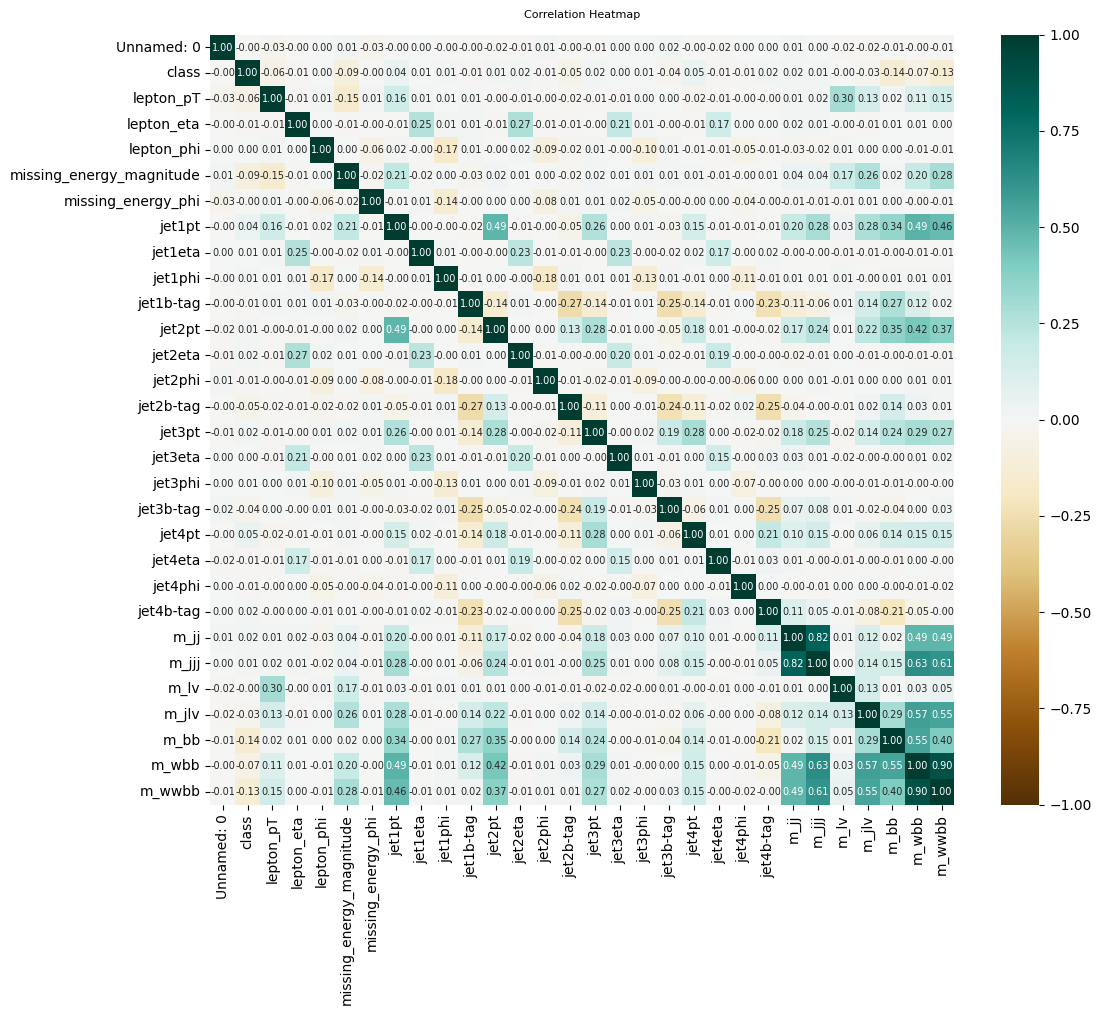

In [11]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG', annot = True, fmt=".2f", annot_kws={"size":7})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=12)

## 6. Pair plots

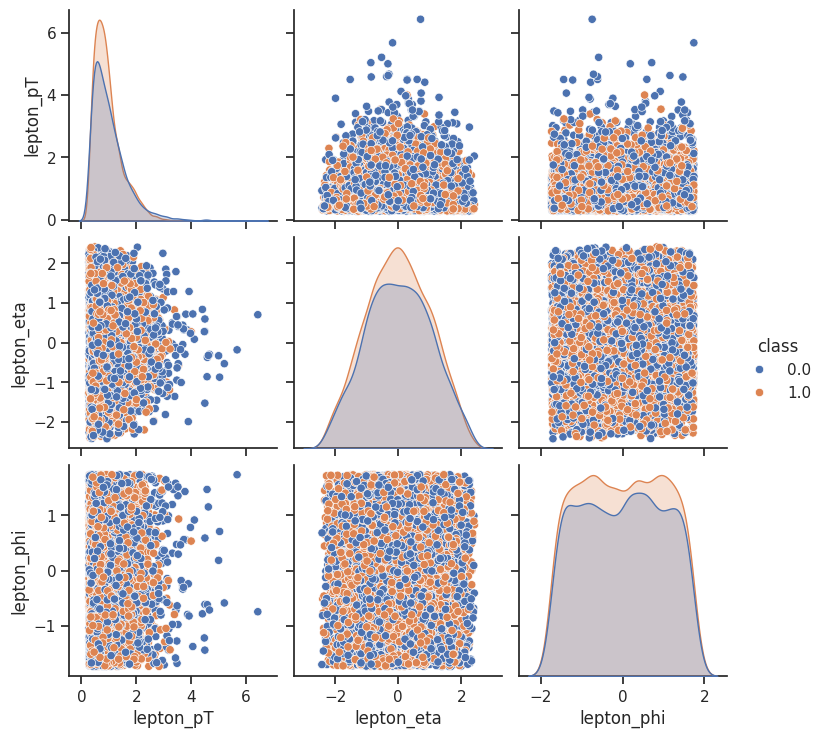

In [12]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df,vars = ['lepton_pT','lepton_eta','lepton_phi'], hue="class")
plt.show()

## 7. Generating training, validation and testing datasets

In [13]:
y = df["class"]
y = y.astype(int)
X = df.iloc[:,2:-1]

In [14]:
X

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,jet2pt,...,jet4pt,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb
0,0.978916,1.844643,-1.422353,0.910926,1.741381,0.836740,1.038726,0.040076,2.173076,0.686552,...,0.795455,0.509227,1.487003,0.000000,0.815551,1.017818,0.981035,1.173383,0.978406,0.987195
1,0.785475,0.947617,1.601191,1.730936,-1.300155,0.898392,0.655507,1.034625,2.173076,0.633672,...,0.556672,-0.129548,-0.258853,0.000000,1.666249,1.403631,0.986471,1.152768,1.342005,1.134370
2,0.572818,-1.231151,-1.497259,0.557409,1.587439,2.817746,0.714921,-0.137981,1.086538,1.868912,...,1.784661,-0.510981,1.181246,3.101961,2.894233,1.823246,0.998267,1.867427,2.785220,2.321026
3,0.548844,2.153391,-0.562318,1.489274,0.248050,1.791746,-0.108951,1.369468,0.000000,1.112861,...,0.883568,-0.621747,1.301107,3.101961,0.934149,0.871509,0.985588,0.821194,1.113907,1.328275
4,0.846600,-0.158811,-1.235365,0.728787,-0.783034,1.155717,-0.462463,-0.844258,1.086538,1.193817,...,0.699552,-1.235538,1.066934,0.000000,0.440971,0.965494,0.985530,1.133286,1.747692,0.984962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,0.799018,-0.317568,1.511859,0.808901,-1.313098,0.535536,-0.907076,0.148179,2.173076,0.491779,...,1.092898,0.610832,-1.040172,0.000000,0.883996,1.002692,0.984474,0.855569,0.289925,0.742003
9801,1.755057,-0.861043,-1.700894,0.830647,0.650778,1.470479,1.164485,0.076110,2.173076,1.250348,...,0.505800,0.773232,-1.299871,0.000000,0.768177,0.988523,1.427038,2.413271,2.241379,1.727108
9802,0.462281,-1.868126,-1.482833,1.340225,1.480284,0.655266,-1.267520,-0.264933,2.173076,0.903106,...,0.594400,0.521720,-0.040773,0.000000,0.972735,1.055439,0.974570,0.861793,0.781094,0.811690
9803,0.477288,1.330387,0.218477,1.115468,-1.129730,0.563293,-0.780327,1.427123,2.173076,0.575883,...,0.719268,-1.241367,-1.415293,0.000000,1.133203,0.827060,0.985745,1.467714,0.744448,1.040776


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  test_size=0.2, random_state=0)
n_classes = 2

## 8. Building a FFNN using Keras

In [16]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import tensorflow  as tf



model = Sequential()
model.add(Dense(300, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(150, activation = "relu"))
model.add(Dense(100, activation = "relu"))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 300)                 │           8,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          45,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,751 (288.09 KB)

 Trainable params: 73,751 (288.09 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
metrics_m = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=SGD(),
               loss='binary_crossentropy',
               metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train, epochs=50,
                    verbose=1,
                    validation_data = (X_val, y_val))

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5218 - loss: 0.6949 - precision: 0.5285 - recall: 0.7567 - val_accuracy: 0.5231 - val_loss: 0.6927 - val_precision: 0.5240 - val_recall: 0.8849
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5456 - loss: 0.6894 - precision: 0.5510 - recall: 0.8738 - val_accuracy: 0.5055 - val_loss: 0.6902 - val_precision: 0.5156 - val_recall: 0.7763
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5589 - loss: 0.6840 - precision: 0.5571 - recall: 0.8173 - val_accuracy: 0.5265 - val_loss: 0.6888 - val_precision: 0.5315 - val_recall: 0.7374
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5692 - loss: 0.6800 - precision: 0.5705 - recall: 0.8220 - val_accuracy: 0.5391 - val_loss: 0.6877 - val_precision: 0.5369 - val_recall: 0.8136
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5750 - loss: 0.6782 - precision: 0.5713 - recall: 0.7894 - val_accuracy: 0.5509 - val_loss: 0.

## 9. Performance metrics

In [18]:
def show_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure()
    plt.plot(train_loss,'r', label="train")
    plt.plot(val_loss,'g', label="validation")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()


def show_metrics(y_pred,th):
    cm = confusion_matrix(y_test, y_pred>th)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    d = classification_report(y_test, y_pred > th,output_dict=True)
    display(pd.DataFrame.from_dict(d))
    return y_pred

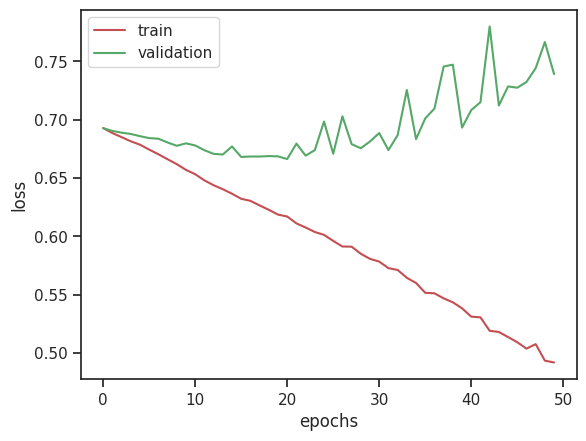

In [19]:
show_history(history)

In [20]:
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob >= 0.5

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [21]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


fpr, tpr, ths = roc_curve(y_test,  y_pred)
auc_ = auc(fpr, tpr)
f1 = f1_score(y_test,  (y_pred>.5))
prec = precision_score(y_test,  (y_pred>.5))
rec = recall_score(y_test,  (y_pred>.5))
acc = accuracy_score(y_test,  (y_pred>.5))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.61  -- prec: 0.63  -- recall: 0.59  -- acc: 0.59


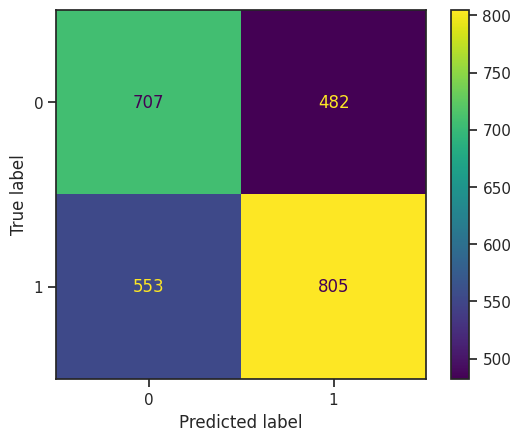

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              )
disp.plot()
plt.show()

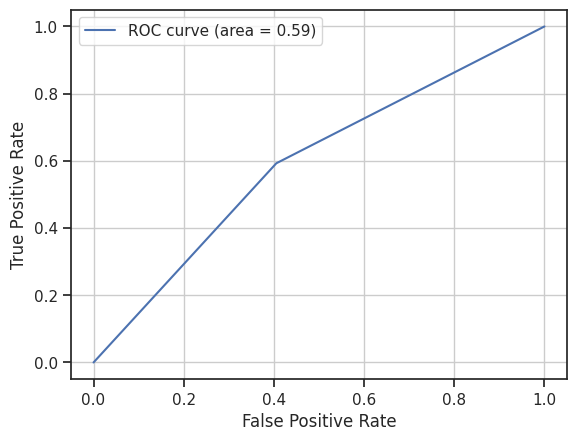

In [23]:
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [24]:
d = classification_report(y_test, y_pred,output_dict=True)

In [25]:
pd.DataFrame.from_dict(d)

,0,1,accuracy,macro avg,weighted avg
precision,0.561111,0.625486,0.59364,0.593298,0.595434
recall,0.594617,0.592784,0.59364,0.593700,0.593640
f1-score,0.577379,0.608696,0.59364,0.593037,0.594076
support,1189.000000,1358.000000,0.59364,2547.000000,2547.000000


## 10. ANN Score plot
***
Histogram of the ANN scores in the testing set

In [37]:
#!pip install mplhep

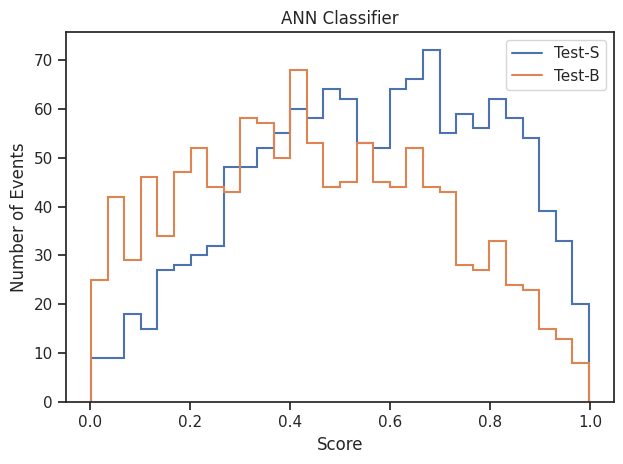

In [36]:
import mplhep as hep
# Score distribution
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_sig_test, bins_sig_test = np.histogram(y_pred_prob[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_prob[y_test == 0], bins=30)
axs.set_title("ANN Classifier")
hep.histplot([h_sig_test, h_back_test], bins_sig_test, ax=axs,label=["Test-S", "Test-B"])
axs.legend()
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")
plt.tight_layout()
plt.show()

## 11. Using keras_tuner
****
 * To find the best hyperparameters for their machine learning models.

In [38]:
#!pip install keras-tuner

In [29]:
import keras_tuner as kt

In [30]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Input Layer
    model.add(Dense(hp.Int('units_input', min_value=50, max_value=300, step=50),
                    input_shape=(X_train.shape[1],), activation='relu'))

    # Hidden Layers
    for i in range(hp.Int('num_hidden_layers', 1, 4)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=50, max_value=300, step=50),
                        activation='relu'))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [31]:
# Instantiate the RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of models to try
    executions_per_trial=2,  # Number of times to train each model
    directory='my_dir',  # Directory to save the tuner results
    project_name='random_search_example'
)

# Search for the best model
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)



Trial 10 Complete [00h 00m 49s]
val_accuracy: 0.6114381849765778

Best val_accuracy So Far: 0.6185870468616486
Total elapsed time: 00h 06m 26s


In [32]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters:\n")
print(f"Input Layer Units: {best_hps.get('units_input')}")
for i in range(best_hps.get('num_hidden_layers')):
    print(f"Hidden Layer {i+1} Units: {best_hps.get(f'units_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model on validation data
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

Best hyperparameters:

Input Layer Units: 150
Hidden Layer 1 Units: 100
Hidden Layer 2 Units: 150
Learning Rate: 0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5278 - loss: 0.7217 - val_accuracy: 0.5568 - val_loss: 0.6799
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5843 - loss: 0.6689 - val_accuracy: 0.5660 - val_loss: 0.6772
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5805 - loss: 0.6660 - val_accuracy: 0.5795 - val_loss: 0.6691
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6128 - loss: 0.6532 - val_accuracy: 0.5660 - val_loss: 0.6782
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6169 - loss: 0.6471 - val_accuracy: 0.5929 - val_loss: 0.6763
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6268 - loss: 0.6438 - val_accuracy: 0.5904 - val_loss: 0.6693
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6310 - loss: 0.6341 - val_accuracy: 0.5795 - val_loss: 0.6706
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6627 - loss: 0.6139 - val_accuracy: 0.

In [33]:
y_pred_prob_2 = best_model.predict(X_test)
y_pred_2 = y_pred_prob_2 >= 0.5

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<div class="alert alert-block alert-success">
<b>Task</b>

<ul>
  <li>Display the performance metrics, confusion matrix, and ANN output (scores) of the best model.</li>
  <li>Modify the tuner to improve the classification performance.</li>
</ul>
    
    
</div>